# installation

In [1]:
%pip install scikit-image pandas matplotlib tqdm torchinfo tensorboard wandb scikit-learn pytorch-msssim

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Config

In [2]:
import os
import torch
import psutil
from util import format
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import DeepLenseSuperresolutionDataset
import matplotlib.pyplot as plt 
from torchinfo import summary
from util import run_experiment_task2, MSE_Metric, PSNR_Metric, SSIM_Metric
import math

# PyTorch imports
import torch.nn as nn
import torch.nn.functional as F



class CONFIG:
    BATCH_SIZE = 4
    
    # limit the data to prototype faster
    DATA_LIMIT = 200
    
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ROUND_NUMBER = 3
    TASK_NAME = "DeepLense2024_task2A"
    DATA_PATH = os.path.join("Data", "Superresolution")
    PORTION_OF_DATA_FOR_TRAINING = 0.8

In [3]:
memory_start = psutil.virtual_memory()
print(f"RAM used : {format(memory_start.used)}")

RAM used : 2.57GB


In [4]:
dataset = DeepLenseSuperresolutionDataset(folder_path=CONFIG.DATA_PATH, 
                                          randomize_dataset=True,
                                          data_limit=CONFIG.DATA_LIMIT)

# do train/val split
dataset_size = len(dataset)
train_size = int(dataset_size * CONFIG.PORTION_OF_DATA_FOR_TRAINING)
val_size = dataset_size - train_size

print(f"splitting into : {train_size} {val_size}")

# splitting dataset 
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"sizes of datasets : len(train)={len(train_dataset)} len(val)={len(val_dataset)}")

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE)

preprocessing :: 100%|██████████| 200/200 [00:00<00:00, 1149.95it/s]

splitting into : 160 40
sizes of datasets : len(train)=160 len(val)=40


In [5]:
# get sample batch, useful for prototyping the architectures
x, y = next(iter(train_loader))

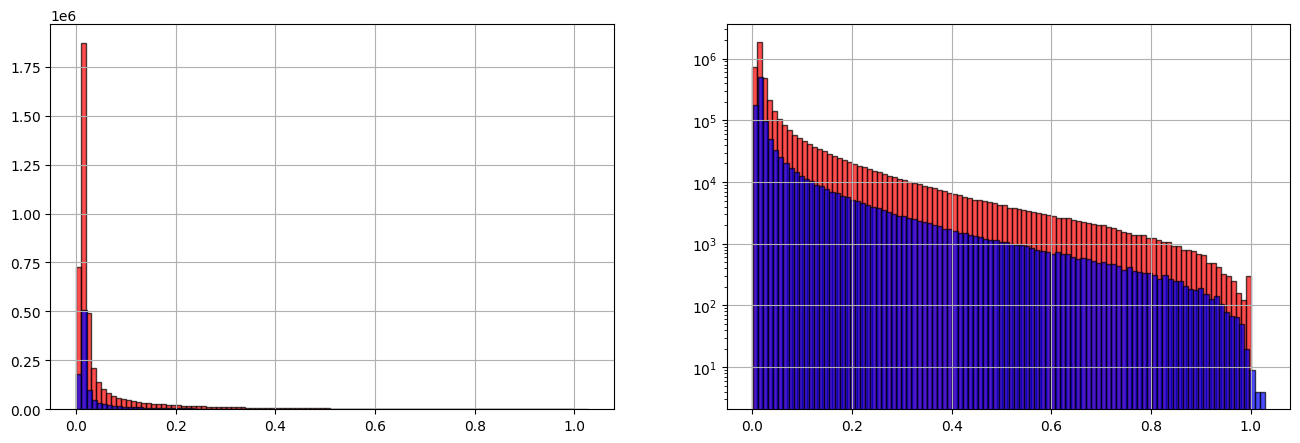

In [6]:
# sanity check 
a = 0.7
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(dataset.HR_data.numpy().reshape(-1), bins=100, color="red", edgecolor="black", alpha=a, label="HR")
plt.hist(dataset.LR_data.numpy().reshape(-1), bins=100, color="blue", edgecolor="black", alpha=a, label="LR")
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(dataset.HR_data.numpy().reshape(-1), bins=100, color="red", edgecolor="black", alpha=a, label="HR")
plt.hist(dataset.LR_data.numpy().reshape(-1), bins=100, color="blue", edgecolor="black", alpha=a, label="LR")
plt.yscale("log")
plt.grid()
plt.show()


In [7]:
try:
    print(f"mean_LR = {dataset.mean_LR.item()} std_LR = {dataset.std_LR.item()}")
except Exception as e:
    print(f"mean_LR = {dataset.mean_LR} std_LR = {dataset.std_LR}")


try:
    print(f"mean_HR = {dataset.mean_HR.item()} std_HR = {dataset.std_HR.item()}")
except Exception as e:
    print(f"mean_HR = {dataset.mean_HR} std_HR = {dataset.std_HR}")
    

memory_after = psutil.virtual_memory()
print(f"RAM used : {format(memory_after.used)}, RAM free : {format(memory_after.free)}, memory used : {format(memory_after.used - memory_start.used)}")

mean_LR = 0.061324529349803925 std_LR = 0.11733044683933258
mean_HR = 0.06132453307509422 std_HR = 0.11728931218385696
RAM used : 2.65GB, RAM free : 3.7GB, memory used : 82.09MB


# SRCNN

Paper : https://arxiv.org/abs/1501.00092

In [19]:

class SRCNN_upsampler(nn.Module):
    def __init__(self) -> None:
        super(SRCNN_upsampler, self).__init__()
        
        self.upsampler = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)        
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, (9, 9), (1, 1), (4, 4)),
            nn.ReLU(True)
        )

        self.map = nn.Sequential(
            nn.Conv2d(128, 64, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True)
        )

        self.reconstruction = nn.Conv2d(64, 1, (5, 5), (1, 1), (2, 2))

        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.upsampler is not None:
            x = self.upsampler(x)
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.map(out)
        out = self.reconstruction(out)
        return out

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                nn.init.zeros_(module.bias.data)

        nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
        nn.init.zeros_(self.reconstruction.bias.data)

## Run for upsampler layer

In [20]:
model  = SRCNN_upsampler()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 75, 75))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN_upsampler                          [4, 1, 150, 150]          --
├─Upsample: 1-1                          [4, 1, 150, 150]          --
├─Sequential: 1-2                        [4, 128, 150, 150]        --
│    └─Conv2d: 2-1                       [4, 128, 150, 150]        10,496
│    └─ReLU: 2-2                         [4, 128, 150, 150]        --
├─Sequential: 1-3                        [4, 64, 150, 150]         --
│    └─Conv2d: 2-3                       [4, 64, 150, 150]         204,864
│    └─ReLU: 2-4                         [4, 64, 150, 150]         --
├─Conv2d: 1-4                            [4, 1, 150, 150]          1,601
Total params: 216,961
Trainable params: 216,961
Non-trainable params: 0
Total mult-adds (G): 19.53
Input size (MB): 0.09
Forward/backward pass size (MB): 138.96
Params size (MB): 0.87
Estimated Total Size (MB): 139.92

In [22]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=SRCNN_upsampler, 
                     run_name="SRCNN_upsample", 
                     model_parameters={}, 
                     epochs=10,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/srcnn_upsample.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     base_lr=1e-4, 
                     test_params={"save_in_total" : 10},
                     max_lr=1e-3,
                     scheduler_en=False,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 160 Mean Squared Error (MSE)=0.017570072896309994 ; PSNR=17.7401259085408 ; SSIM=0.2205320365211499 ; : 100%|██████████| 40/40 [00:00<00:00, 52.15it/s]   
examples seen so far : 40 Mean Squared Error (MSE)=0.017035331123341352 ; PSNR=17.84600597073752 ; SSIM=0.2159556765586902 ; : 100%|██████████| 10/10 [00:00<00:00, 31.56it/s] 
EPOCH : 0, average loss : 0.00533578570903046: 100%|██████████| 40/40 [00:00<00:00, 56.78it/s]  
examples seen so far : 160 Mean Squared Error (MSE)=0.0006488986359469874 ; PSNR=32.140559633793714 ; SSIM=0.9276132733566956 ; : 100%|██████████| 40/40 [00:00<00:00, 55.45it/s]
examples seen so far : 40 Mean Squared Error (MSE)=0.0005907403687253976 ; PSNR=32.54632755803982 ; SSIM=0.9288816986939846 ; : 100%|██████████| 10/10 [00:00<00:00, 37.20it/s]
EPOCH : 1, average loss : 0.0005498850528965704: 100%|██████████| 40/40 [00:00<00:00, 70.46it/s]
examples seen so far : 160 Mean Squared Error (MSE)=0.0004047514752150988 ; PSNR=34.20741428661958

loss,█▂▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▅▆▇███████
train_SSIM,▁██████████
val_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▅▆▇███████
val_SSIM,▁██████████
loss,8e-05
train_Mean Squared Error (MSE),8e-05
train_PSNR,41.27788
train_SSIM,0.96824


In [17]:
model  = SRCNN_upsampler()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 75, 75))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN                                    [4, 1, 150, 150]          --
├─ConvTranspose2d: 1-1                   [4, 1, 150, 150]          5
├─Sequential: 1-2                        [4, 128, 150, 150]        --
│    └─Conv2d: 2-1                       [4, 128, 150, 150]        10,496
│    └─ReLU: 2-2                         [4, 128, 150, 150]        --
├─Sequential: 1-3                        [4, 64, 150, 150]         --
│    └─Conv2d: 2-3                       [4, 64, 150, 150]         204,864
│    └─ReLU: 2-4                         [4, 64, 150, 150]         --
├─Conv2d: 1-4                            [4, 1, 150, 150]          1,601
Total params: 216,966
Trainable params: 216,966
Non-trainable params: 0
Total mult-adds (G): 19.53
Input size (MB): 0.09
Forward/backward pass size (MB): 139.68
Params size (MB): 0.87
Estimated Total Size (MB): 140.64

## Run for Conv2DTranspose

In [28]:

class SRCNN_conv2DTranspose(nn.Module):
    def __init__(self) -> None:
        super(SRCNN_conv2DTranspose, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, (9, 9), (1, 1), (4, 4)),
            nn.ReLU(True)
        )

        self.map = nn.Sequential(
            nn.Conv2d(128, 64, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True)
        )
        
        self.upsampler = nn.ConvTranspose2d(64, 64, (3, 3), stride=2, padding=1, output_padding=1)

        self.reconstruction = nn.Conv2d(64, 1, (5, 5), (1, 1), (2, 2))

        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.map(out)
        out = self.upsampler(out)
        out = self.reconstruction(out)
        return out

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                nn.init.zeros_(module.bias.data)

        nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
        nn.init.zeros_(self.reconstruction.bias.data)

In [29]:
model  = SRCNN_conv2DTranspose()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 75, 75))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN_conv2DTranspose                    [4, 1, 150, 150]          --
├─Sequential: 1-1                        [4, 128, 75, 75]          --
│    └─Conv2d: 2-1                       [4, 128, 75, 75]          10,496
│    └─ReLU: 2-2                         [4, 128, 75, 75]          --
├─Sequential: 1-2                        [4, 64, 75, 75]           --
│    └─Conv2d: 2-3                       [4, 64, 75, 75]           204,864
│    └─ReLU: 2-4                         [4, 64, 75, 75]           --
├─ConvTranspose2d: 1-3                   [4, 64, 150, 150]         36,928
├─Conv2d: 1-4                            [4, 1, 150, 150]          1,601
Total params: 253,889
Trainable params: 253,889
Non-trainable params: 0
Total mult-adds (G): 8.31
Input size (MB): 0.09
Forward/backward pass size (MB): 81.36
Params size (MB): 1.02
Estimated Total Size (MB): 82.47

In [30]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=SRCNN_conv2DTranspose, 
                     run_name="SRCNN_conv2DTranspose", 
                     model_parameters={}, 
                     epochs=30,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/srcnn_upsample.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     base_lr=1e-4, 
                     test_params={"save_in_total" : 10},
                     max_lr=1e-3,
                     scheduler_en=False,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


examples seen so far : 160 Mean Squared Error (MSE)=0.01753176072225818 ; PSNR=17.750210403374037 ; SSIM=0.24602452192291524 ; : 100%|██████████| 40/40 [00:01<00:00, 33.29it/s]
examples seen so far : 40 Mean Squared Error (MSE)=0.01699721636489416 ; PSNR=17.85624247532975 ; SSIM=0.24144518146148095 ; : 100%|██████████| 10/10 [00:00<00:00, 28.54it/s] 
EPOCH : 0, average loss : 0.009168789623072372: 100%|██████████| 40/40 [00:00<00:00, 66.34it/s]
examples seen so far : 160 Mean Squared Error (MSE)=0.0025848808629532 ; PSNR=26.047738379640926 ; SSIM=0.6788877132553724 ; : 100%|██████████| 40/40 [00:00<00:00, 59.41it/s]   
examples seen so far : 40 Mean Squared Error (MSE)=0.0024310615456973514 ; PSNR=26.292729154298957 ; SSIM=0.6841057095772181 ; : 100%|██████████| 10/10 [00:00<00:00, 49.54it/s]
EPOCH : 1, average loss : 0.0012000553258985746: 100%|██████████| 40/40 [00:00<00:00, 130.48it/s]
examples seen so far : 160 Mean Squared Error (MSE)=0.0005094226683656914 ; PSNR=33.18394959570184

loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▃▆▇▇▇▇████████████████████████
train_SSIM,▁▅▇████████████████████████████
val_Mean Squared Error (MSE),█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▄▆▇▇▇█████████████████████████
val_SSIM,▁▅▇████████████████████████████
loss,8e-05
train_Mean Squared Error (MSE),8e-05
train_PSNR,41.14068
train_SSIM,0.96719


# Enhanced Deep Super-Resolution Network
Paper : https://arxiv.org/abs/1707.02921

## EDSR with upsampler

In [34]:
import torch
import torch.nn as nn

class EDSRBlock(nn.Module):
    def __init__(self, n_feats):
        super(EDSRBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        return x + res

class EDSR_upsampler(nn.Module):
    def __init__(self, n_blocks=16, n_feats=64):
        super(EDSR_upsampler, self).__init__()
        self.upsampler = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)        
        self.conv1 = nn.Conv2d(1, n_feats, kernel_size=3, padding=1)
        self.blocks = nn.Sequential(*[EDSRBlock(n_feats) for _ in range(n_blocks)])
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_feats, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.upsampler(x)
        x = self.conv1(x)
        res = self.blocks(x)
        res = self.conv2(res)
        res += x
        x = self.conv3(res)
        return x


model  = EDSR_upsampler()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 75, 75))

Layer (type:depth-idx)                   Output Shape              Param #
EDSR_upsampler                           [4, 1, 150, 150]          --
├─Upsample: 1-1                          [4, 1, 150, 150]          --
├─Conv2d: 1-2                            [4, 64, 150, 150]         640
├─Sequential: 1-3                        [4, 64, 150, 150]         --
│    └─EDSRBlock: 2-1                    [4, 64, 150, 150]         --
│    │    └─Conv2d: 3-1                  [4, 64, 150, 150]         36,928
│    │    └─ReLU: 3-2                    [4, 64, 150, 150]         --
│    │    └─Conv2d: 3-3                  [4, 64, 150, 150]         36,928
│    └─EDSRBlock: 2-2                    [4, 64, 150, 150]         --
│    │    └─Conv2d: 3-4                  [4, 64, 150, 150]         36,928
│    │    └─ReLU: 3-5                    [4, 64, 150, 150]         --
│    │    └─Conv2d: 3-6                  [4, 64, 150, 150]         36,928
│    └─EDSRBlock: 2-3                    [4, 64, 150, 150]         -

In [35]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_upsampler, 
                     run_name="EDSR_upsampler", 
                     model_parameters={}, 
                     epochs=30,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_upsampler.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     base_lr=1e-4, 
                     test_params={"save_in_total" : 10},
                     max_lr=1e-3,
                     scheduler_en=False,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 160 Mean Squared Error (MSE)=0.04620234971666861 ; PSNR=13.491143428432425 ; SSIM=-0.3830049825164507 ; : 100%|██████████| 40/40 [00:01<00:00, 24.64it/s] 
examples seen so far : 40 Mean Squared Error (MSE)=0.04509575196947807 ; PSNR=13.571363316386352 ; SSIM=-0.38961910819395995 ; : 100%|██████████| 10/10 [00:00<00:00, 22.60it/s]
EPOCH : 0, average loss : 0.0034201921916974243: 100%|██████████| 40/40 [00:03<00:00, 11.92it/s]
examples seen so far : 160 Mean Squared Error (MSE)=0.00017684181264759796 ; PSNR=37.54950798733284 ; SSIM=0.8006960490964493 ; : 100%|██████████| 40/40 [00:01<00:00, 25.27it/s] 
examples seen so far : 40 Mean Squared Error (MSE)=0.0001735833819764547 ; PSNR=37.61875450847862 ; SSIM=0.8029374541380466 ; : 100%|██████████| 10/10 [00:00<00:00, 23.34it/s] 
EPOCH : 1, average loss : 9.210138723574346e-05: 100%|██████████| 40/40 [00:03<00:00, 12.18it/s] 
examples seen so far : 160 Mean Squared Error (MSE)=7.523103390982135e-05 ; PSNR=41.2750387132

loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▇████████████████████████████▇
train_SSIM,▁▇█████████████████████████████
val_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▇████████████████████████████▇
val_SSIM,▁▇█████████████████████████████
loss,0.0001
train_Mean Squared Error (MSE),0.00012
train_PSNR,39.15569
train_SSIM,0.92826


## EDSR with Conv2DTranspose

In [39]:
import torch
import torch.nn as nn

class EDSRBlock(nn.Module):
    def __init__(self, n_feats):
        super(EDSRBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        return x + res

class EDSR_conv2DTranspose(nn.Module):
    def __init__(self, n_blocks=16, n_feats=64):
        super(EDSR_conv2DTranspose, self).__init__()
        self.conv1 = nn.Conv2d(1, n_feats, kernel_size=3, padding=1)
        self.blocks = nn.Sequential(*[EDSRBlock(n_feats) for _ in range(n_blocks)])
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.upsampler = nn.ConvTranspose2d(n_feats, n_feats, (3,3), stride=2, padding=1, output_padding=1)
        self.conv3 = nn.Conv2d(n_feats, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        res = self.blocks(x)
        res = self.conv2(res)
        res += x
        res = self.upsampler(res)
        x = self.conv3(res)
        return x


model  = EDSR_conv2DTranspose()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 75, 75))

Layer (type:depth-idx)                   Output Shape              Param #
EDSR_conv2DTranspose                     [4, 1, 150, 150]          --
├─Conv2d: 1-1                            [4, 64, 75, 75]           640
├─Sequential: 1-2                        [4, 64, 75, 75]           --
│    └─EDSRBlock: 2-1                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-1                  [4, 64, 75, 75]           36,928
│    │    └─ReLU: 3-2                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-3                  [4, 64, 75, 75]           36,928
│    └─EDSRBlock: 2-2                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-4                  [4, 64, 75, 75]           36,928
│    │    └─ReLU: 3-5                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-6                  [4, 64, 75, 75]           36,928
│    └─EDSRBlock: 2-3                    [4, 64, 75, 75]           --
│    │    └─Conv2d: 3-7                  [4, 64, 75, 75]           3

In [40]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_conv2DTranspose, 
                     run_name="EDSR_conv2DTranspose", 
                     model_parameters={}, 
                     epochs=30,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_upEDSR_conv2DTransposesampler.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     base_lr=1e-4, 
                     test_params={"save_in_total" : 10},
                     max_lr=1e-3,
                     scheduler_en=False,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 160 Mean Squared Error (MSE)=0.02341890090244746 ; PSNR=16.451554649247452 ; SSIM=-0.24278511463096306 ; : 100%|██████████| 40/40 [00:01<00:00, 38.43it/s] 
examples seen so far : 40 Mean Squared Error (MSE)=0.022840770582358044 ; PSNR=16.53549123152217 ; SSIM=-0.24458613303991464 ; : 100%|██████████| 10/10 [00:00<00:00, 26.82it/s]
EPOCH : 0, average loss : 0.002297580127924448: 100%|██████████| 40/40 [00:01<00:00, 32.72it/s] 
examples seen so far : 160 Mean Squared Error (MSE)=0.00020532749248038885 ; PSNR=36.97566693148311 ; SSIM=0.9438491924753729 ; : 100%|██████████| 40/40 [00:00<00:00, 41.43it/s] 
examples seen so far : 40 Mean Squared Error (MSE)=0.0001946314721583174 ; PSNR=37.1754737249216 ; SSIM=0.9432279406449734 ; : 100%|██████████| 10/10 [00:00<00:00, 37.22it/s] 
EPOCH : 1, average loss : 0.00013025975113123422: 100%|██████████| 40/40 [00:01<00:00, 35.58it/s]
examples seen so far : 160 Mean Squared Error (MSE)=0.0001000034993601547 ; PSNR=40.0573959917

loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▇▇████████████████████████████
train_SSIM,▁██████████████████████████████
val_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▇▇████████████████████████████
val_SSIM,▁██████████████████████████████
loss,6e-05
train_Mean Squared Error (MSE),6e-05
train_PSNR,42.22877
train_SSIM,0.97395


# Residual Dense Network for Image Super-Resolution

Paper: https://arxiv.org/pdf/1802.08797v2.pdf

In [ ]:
import torch
from torch import nn


class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return torch.cat([x, self.relu(self.conv(x))], 1)


class RDB(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(RDB, self).__init__()
        self.layers = nn.Sequential(*[DenseLayer(in_channels + growth_rate * i, growth_rate) for i in range(num_layers)])

        # local feature fusion
        self.lff = nn.Conv2d(in_channels + growth_rate * num_layers, growth_rate, kernel_size=1)

    def forward(self, x):
        return x + self.lff(self.layers(x))  # local residual learning


class RDN(nn.Module):
    def __init__(self, scale_factor, num_channels, num_features, growth_rate, num_blocks, num_layers):
        super(RDN, self).__init__()
        self.G0 = num_features
        self.G = growth_rate
        self.D = num_blocks
        self.C = num_layers

        # shallow feature extraction
        self.sfe1 = nn.Conv2d(num_channels, num_features, kernel_size=3, padding=3 // 2)
        self.sfe2 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=3 // 2)

        # residual dense blocks
        self.rdbs = nn.ModuleList([RDB(self.G0, self.G, self.C)])
        for _ in range(self.D - 1):
            self.rdbs.append(RDB(self.G, self.G, self.C))

        # global feature fusion
        self.gff = nn.Sequential(
            nn.Conv2d(self.G * self.D, self.G0, kernel_size=1),
            nn.Conv2d(self.G0, self.G0, kernel_size=3, padding=3 // 2)
        )

        # up-sampling
        assert 2 <= scale_factor <= 4
        if scale_factor == 2 or scale_factor == 4:
            self.upscale = []
            for _ in range(scale_factor // 2):
                self.upscale.extend([nn.Conv2d(self.G0, self.G0 * (2 ** 2), kernel_size=3, padding=3 // 2),
                                     nn.PixelShuffle(2)])
            self.upscale = nn.Sequential(*self.upscale)
        else:
            self.upscale = nn.Sequential(
                nn.Conv2d(self.G0, self.G0 * (scale_factor ** 2), kernel_size=3, padding=3 // 2),
                nn.PixelShuffle(scale_factor)
            )

        self.output = nn.Conv2d(self.G0, num_channels, kernel_size=3, padding=3 // 2)

    def forward(self, x):
        print(x.shape)
        sfe1 = self.sfe1(x)
        print(sfe1.shape)
        sfe2 = self.sfe2(sfe1)

        x = sfe2
        local_features = []
        for i in range(self.D):
            x = self.rdbs[i](x)
            local_features.append(x)

        x = self.gff(torch.cat(local_features, 1)) + sfe1  # global residual learning
        x = self.upscale(x)
        x = self.output(x)
        return x
    
model = RDN(scale_factor=2, num_channels=64, num_features=1, growth_rate=1, num_blocks=3, num_layers=3)
model(x).shape

RuntimeError: Given groups=1, weight of size [1, 64, 3, 3], expected input[4, 1, 75, 75] to have 64 channels, but got 1 channels instead

RuntimeError: Given groups=1, weight of size [1, 64, 3, 3], expected input[4, 1, 75, 75] to have 64 channels, but got 1 channels instead

: 